In [20]:
import pandas as pd

FILEPATH = './data/'
TRAIN_ROWS = 100000
TEST_ROWS = 10000
VAL_ROWS = 10000

df_train = pd.read_csv(FILEPATH + 'train.csv', nrows=TRAIN_ROWS)
df_val = pd.read_csv(FILEPATH + 'val.csv', nrows=VAL_ROWS)
df_test = pd.read_csv(FILEPATH + 'test.csv', nrows=TEST_ROWS)

print(df_train.head)

<bound method NDFrame.head of                                 chief_complaint     major_surgical_procedure  \
0               infected sacral decubitus ulcer               line placement   
1                                     Abdominal                          NaN   
2                             neck pain s/p MVA                          NaN   
3                                      seizures                          NaN   
4                                    Presyncope                          NaN   
...                                         ...                          ...   
99995                            Abdominal Pain  : laparoscopic appendectomy   
99996  Shortness of breath, dyspnea on exertion         IVC filter placement   
99997                       Shortness of Breath                          NaN   
99998                            Abdominal pain                          NaN   
99999                                   Dyspnea                          NaN   

         

In [21]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import re
import pandas as pd

negation_words = {'no', 'not', 'nor', 'neither', 'never', 'denies', 'without'}
SKLEARN_STOPWORDS = set(ENGLISH_STOP_WORDS) - negation_words

medical_stopwords = {
    'pt', 'patient', 'hx', 'ros', 'admitted', 'hospital', # Am scos 'denies'
    'history', 'illness', 'presenting', 'states', 'reportedly', 'due',
    'mg', 'capsule', 'tablet', 'solution', 'drops', 'daily', 'tid', 'bid',
    'po', 'iv', 'unit', 'vitals', 'flow',
    'rr', 'bp', 'temp', 'pulse', 'w', 'h', 'm', 'f', 'o', 'r', 'q', 'g',
    'cc', 'cxr', 'us', 'chief'
}
ALL_STOPWORDS = SKLEARN_STOPWORDS.union(medical_stopwords)

INPUT_COLUMNS = ['chief_complaint', 'history_of_present_illness', 'past_medical_history']

def clean_text(text, stop_words):
    if pd.isna(text) or text is None:
        return ""

    text = str(text).lower()
    text = re.sub(r'(\s+in\s+)|(\s+at\s+)|(sometime\s+in\s+)|(\s*\d{4}\s*)|(\s*ms\.\s*,\s*)', ' ', text)
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)

    tokens = text.split()

    # Condiția len(token) > 1 permite acronime de 2 litere
    filtered_tokens = [token for token in tokens if token not in stop_words and len(token) > 1]

    return " ".join(filtered_tokens)

def generate_processed_input(row):
    input_parts = []
    for col in INPUT_COLUMNS:
        # Verificăm dacă coloana există în dataframe pentru a evita erori
        if col in row:
            cleaned_data = clean_text(row[col], ALL_STOPWORDS)
            if cleaned_data:
                label = col.upper().replace("_", " ")
                input_parts.append(f'{label}: {cleaned_data}')

    # Returnăm string-ul cu separatorul.
    return ' | '.join(input_parts)

print('End')

End


In [25]:
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics.pairwise import cosine_similarity
import torch.nn.functional as F

tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-v1.1")
model = AutoModel.from_pretrained("dmis-lab/biobert-v1.1")

# specialist definitions for embeddings generation
specialist_definitions = {
    "Infectious_Disease": (
        "Diagnosis and management of infections caused by bacteria, viruses, fungi, and parasites. "
        "Conditions include sepsis, septic shock, bacteremia, pneumonia, meningitis, and abscesses. "
        "Treatment involves broad-spectrum antibiotics (vancomycin, zosyn, cefepime), antivirals, "
        "fevers, chills, leukocytosis, and positive cultures."
    ),

    "Cardiology": (
        "Diseases of the heart and vascular system. Conditions include coronary artery disease (CAD), "
        "myocardial infarction (MI), congestive heart failure (CHF), atrial fibrillation (Afib), "
        "arrhythmia, hypertension, and angina. Treatments involving anticoagulation (heparin, warfarin), "
        "diuretics (lasix), beta-blockers, ACE inhibitors, cardiac catheterization, and stents."
    ),

    "Orthopedics_Surgery": (
        "Surgical and non-surgical treatment of the musculoskeletal system, bones, joints, and muscles. "
        "Conditions include bone fractures, trauma, osteoarthritis, hip and knee pain. "
        "Procedures include Open Reduction Internal Fixation (ORIF), arthroplasty, debridement, "
        "amputation, and casting. Post-operative care for orthopedic injuries."
    ),

    "Oncology": (
        "Diagnosis and treatment of cancer, malignancies, neoplasms, and tumors. "
        "Includes management of metastasis, lymphoma, leukemia, carcinoma, and masses. "
        "Therapies involve chemotherapy, immunotherapy, radiation, and palliative care for terminal illness."
    ),

    "Pulmonology": (
        "Diseases of the respiratory system, lungs, and airways. "
        "Conditions include pneumonia, chronic obstructive pulmonary disease (COPD), asthma, "
        "emphysema, bronchitis, pulmonary embolism (PE), and pleural effusion. "
        "Symptoms include dyspnea, shortness of breath, hypoxia, respiratory failure, and cough. "
        "Use of bronchodilators and oxygen therapy."
    ),

    "Endocrinology": (
        "Disorders of the endocrine system, hormones, and metabolism. "
        "Primary focus on Diabetes Mellitus (Type 1 and Type 2), diabetic ketoacidosis (DKA), "
        "hyperglycemia, and hypoglycemia. Also thyroid disorders (hypothyroidism, hyperthyroidism), "
        "adrenal insufficiency, and lipid disorders. Insulin management and glucose control."
    ),

    "Gastroenterology": (
        "Diseases of the digestive tract, stomach, intestines, liver, pancreas, and gallbladder. "
        "Conditions include gastrointestinal bleeding (GI bleed), cirrhosis, hepatitis, pancreatitis, "
        "bowel obstruction, melena, and hematochezia. Symptoms of nausea, vomiting, diarrhea, "
        "and abdominal pain. Procedures like endoscopy and colonoscopy."
    ),

    "Neurology": (
        "Disorders of the nervous system, brain, spinal cord, and nerves. "
        "Conditions include cerebrovascular accidents (CVA), stroke, transient ischemic attack (TIA), "
        "seizures, epilepsy, encephalopathy, and neuropathy. "
        "Symptoms include altered mental status, confusion, headache, weakness, numbness, "
        "syncope, and dizziness."
    )
}

specialist_names = list(specialist_definitions.keys())

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(DEVICE)
print(f"Running on: {DEVICE}")

def get_single_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512).to(DEVICE)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state[:, 0, :]

specialist_tensors_list = [get_single_embedding(specialist_definitions[spec]) for spec in specialist_names]
specialist_matrix = torch.cat(specialist_tensors_list, dim=0)
specialist_matrix_norm = F.normalize(specialist_matrix, p=2, dim=1)

def label_batch_gpu(examples):

    inputs = tokenizer(
        examples['input_text'], 
        padding=True, 
        truncation=True, 
        max_length=512, 
        return_tensors="pt"
    ).to(DEVICE)

    with torch.no_grad():
        outputs = model(**inputs)
        patient_embeddings = outputs.last_hidden_state[:, 0, :]
        
    patient_embeddings_norm = F.normalize(patient_embeddings, p=2, dim=1)
    similarity_scores = torch.mm(patient_embeddings_norm, specialist_matrix_norm.T)
    best_indices = torch.argmax(similarity_scores, dim=1).cpu().numpy()
    
    predicted_labels = [int(idx) for idx in best_indices]
    predicted_names = [specialist_names[idx] for idx in best_indices]
    
    return {"labels": predicted_labels, "specialist_name": predicted_names}

print('End')

Running on: cuda
End


In [29]:
from datasets import Dataset, DatasetDict

df_train_processed = Dataset.from_pandas(process_data_pandas_only(df_train))
df_val_processed = Dataset.from_pandas(process_data_pandas_only(df_val))
df_test_processed = Dataset.from_pandas(process_data_pandas_only(df_test))

datasets = DatasetDict({
    'train': df_train_processed,
    'val': df_val_processed,
    'test': df_test_processed
})

datasets_labeled = datasets.map(
    label_batch_gpu,
    batched=True,
    batch_size=256 
)

print("Etichetare finalizată! Trecem la tokenizarea pentru antrenament.")

def tokenize_for_training(examples):
    return tokenizer(
        examples["input_text"],
        truncation=True,
        max_length=512
    )

final_datasets = datasets_labeled.map(tokenize_for_training, batched=True)

cols_to_remove = [col for col in final_datasets['train'].column_names if col not in ['input_ids', 'attention_mask', 'labels']]
final_datasets = final_datasets.remove_columns(cols_to_remove)

final_datasets.set_format("torch")

Map: 100%|██████████| 10000/10000 [01:02<00:00, 159.98 examples/s]


Etichetare finalizată! Trecem la tokenizarea pentru antrenament.


Map: 100%|██████████| 10000/10000 [00:01<00:00, 5696.27 examples/s]


In [41]:
import torch
import numpy as np
from transformers import DataCollatorWithPadding
from torch.utils.data import DataLoader
from sklearn.utils.class_weight import compute_class_weight

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
BATCH_SIZE = 32

train_dataloader = DataLoader(
    final_datasets["train"], 
    shuffle=True, 
    batch_size=BATCH_SIZE, 
    collate_fn=data_collator
)
eval_dataloader = DataLoader(
    final_datasets["val"], 
    batch_size=BATCH_SIZE, 
    collate_fn=data_collator
)
test_dataloader = DataLoader(
    final_datasets["test"], 
    batch_size=BATCH_SIZE, 
    collate_fn=data_collator
)

print("Calculăm greutățile claselor pentru a corecta dezechilibrul...")
train_labels = np.array(final_datasets["train"]["labels"])

class_weights_np = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights = torch.tensor(class_weights_np, dtype=torch.float).to(DEVICE)

print(f"Class Weights: {class_weights}")

Calculăm greutățile claselor pentru a corecta dezechilibrul...
Class Weights: tensor([3.1250e+03, 4.7601e+00, 3.1017e+01, 6.0340e-01, 4.3430e-01, 2.5510e+02,
        3.5704e-01, 1.0073e+00], device='cuda:0')


In [43]:
from transformers import AutoModelForSequenceClassification, get_linear_schedule_with_warmup
from torch.optim import AdamW

label_to_id = {label: i for i, label in enumerate(specialist_definitions)}

NUM_LABELS = len(label_to_id)

MODEL_NAME = "dmis-lab/biobert-base-cased-v1.2"
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=NUM_LABELS,
    id2label=id_to_label,
    label2id=label_to_id
)
model.to(DEVICE)

LEARNING_RATE = 2e-5
EPOCHS = 5

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)

# Scheduler: Crește LR ușor la început (warmup), apoi scade liniar
total_steps = len(train_dataloader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * total_steps), # 10% warmup
    num_training_steps=total_steps
)

loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [44]:
from tqdm.auto import tqdm
from sklearn.metrics import f1_score, accuracy_score

def evaluate(model, dataloader):
    model.eval()
    preds_all, labels_all = [], []
    
    with torch.no_grad():
        for batch in dataloader:
            # Mutăm batch-ul pe GPU
            batch = {k: v.to(DEVICE) for k, v in batch.items()}
            
            outputs = model(**batch)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=-1)
            
            preds_all.extend(preds.cpu().numpy())
            labels_all.extend(batch["labels"].cpu().numpy())
            
    acc = accuracy_score(labels_all, preds_all)
    f1 = f1_score(labels_all, preds_all, average='macro')
    return acc, f1

best_f1 = 0
best_model_path = "./model/best_biobert_specialist_model"

print("\n Începem antrenarea...")

for epoch in range(EPOCHS):
    model.train()
    total_train_loss = 0
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{EPOCHS}")
    
    for batch in progress_bar:
        batch = {k: v.to(DEVICE) for k, v in batch.items()}
        optimizer.zero_grad()        
        outputs = model(**batch)      

        loss = loss_fct(outputs.logits, batch["labels"])
        loss.backward()
        
        optimizer.step()
        scheduler.step()
        
        total_train_loss += loss.item()
        progress_bar.set_postfix({"loss": f"{loss.item():.4f}"})
        
    avg_train_loss = total_train_loss / len(train_dataloader)
    
    val_acc, val_f1 = evaluate(model, eval_dataloader)
    print(f"\n Epoch {epoch+1} done. Train Loss: {avg_train_loss:.4f} | Val Acc: {val_acc:.4f} | Val F1 (Macro): {val_f1:.4f}")
    
    if val_f1 > best_f1:
        best_f1 = val_f1
        print(f"New Best F1! Saving model to {best_model_path}...")
        model.save_pretrained(best_model_path)
        tokenizer.save_pretrained(best_model_path)

print("\n Antrenare finalizată!")


 Începem antrenarea...


Epoch 1/5: 100%|██████████| 3125/3125 [32:08<00:00,  1.62it/s, loss=0.6904]



 Epoch 1 done. Train Loss: 1.0516 | Val Acc: 0.6240 | Val F1 (Macro): 0.4157
New Best F1! Saving model to ./model/best_biobert_specialist_model...


Epoch 2/5: 100%|██████████| 3125/3125 [32:07<00:00,  1.62it/s, loss=0.1416]



 Epoch 2 done. Train Loss: 0.6653 | Val Acc: 0.7056 | Val F1 (Macro): 0.4581
New Best F1! Saving model to ./model/best_biobert_specialist_model...


Epoch 3/5: 100%|██████████| 3125/3125 [32:06<00:00,  1.62it/s, loss=0.3882]



 Epoch 3 done. Train Loss: 0.4986 | Val Acc: 0.7233 | Val F1 (Macro): 0.5111
New Best F1! Saving model to ./model/best_biobert_specialist_model...


Epoch 4/5: 100%|██████████| 3125/3125 [32:04<00:00,  1.62it/s, loss=0.2309]



 Epoch 4 done. Train Loss: 0.3824 | Val Acc: 0.7689 | Val F1 (Macro): 0.5482
New Best F1! Saving model to ./model/best_biobert_specialist_model...


Epoch 5/5: 100%|██████████| 3125/3125 [32:04<00:00,  1.62it/s, loss=0.0877]



 Epoch 5 done. Train Loss: 0.3037 | Val Acc: 0.7706 | Val F1 (Macro): 0.5332

 Antrenare finalizată!


In [58]:
import torch
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, classification_report
from transformers import AutoModelForSequenceClassification

best_model_path = "./model/best_biobert_specialist_model"

# 1. Încărcăm modelul salvat (State Dict + Configurație)
print(f"Încărcăm cel mai bun model din: {best_model_path}")
final_model = AutoModelForSequenceClassification.from_pretrained(best_model_path)
final_model.to(DEVICE)
final_model.eval()

predictions = []
true_labels = []

print("Rulăm evaluarea pe setul de testare...")
with torch.no_grad():
    for batch in test_dataloader:
        batch = {k: v.to(DEVICE) for k, v in batch.items()}
        
        outputs = final_model(**batch)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=-1)
        
        predictions.extend(preds.cpu().numpy())
        true_labels.extend(batch["labels"].cpu().numpy())

accuracy = accuracy_score(true_labels, predictions)
f1_weighted = f1_score(true_labels, predictions, average='weighted')

print(f"\n Acuratețe Finală pe Test: {accuracy:.4f}")
print(f"F1-Weighted Score: {f1_weighted:.4f}")

id_to_label = id_to_label = {i: label for i, label in enumerate(specialist_definitions)}

target_names = [id_to_label[i] for i in range(len(id_to_label))]
print("\n Classification Report:")
print(classification_report(true_labels, predictions, target_names=target_names, labels=range(NUM_LABELS)))

Încărcăm cel mai bun model din: ./model/best_biobert_specialist_model
Rulăm evaluarea pe setul de testare...

 Acuratețe Finală pe Test: 0.7737
F1-Weighted Score: 0.7752

 Classification Report:
                     precision    recall  f1-score   support

 Infectious_Disease       0.00      0.00      0.00         0
         Cardiology       0.50      0.79      0.61       238
Orthopedics_Surgery       0.30      0.44      0.36        36
           Oncology       0.76      0.69      0.72      2117
        Pulmonology       0.76      0.80      0.78      2835
      Endocrinology       0.00      0.00      0.00         4
   Gastroenterology       0.85      0.78      0.81      3513
          Neurology       0.76      0.84      0.80      1257

           accuracy                           0.77     10000
          macro avg       0.49      0.54      0.51     10000
       weighted avg       0.78      0.77      0.78     10000



/bigdata/userhome/students/md5_sade46ed0dc41367bf7aa9a98922/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/bigdata/userhome/students/md5_sade46ed0dc41367bf7aa9a98922/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/bigdata/userhome/students/md5_sade46ed0dc41367bf7aa9a98922/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero

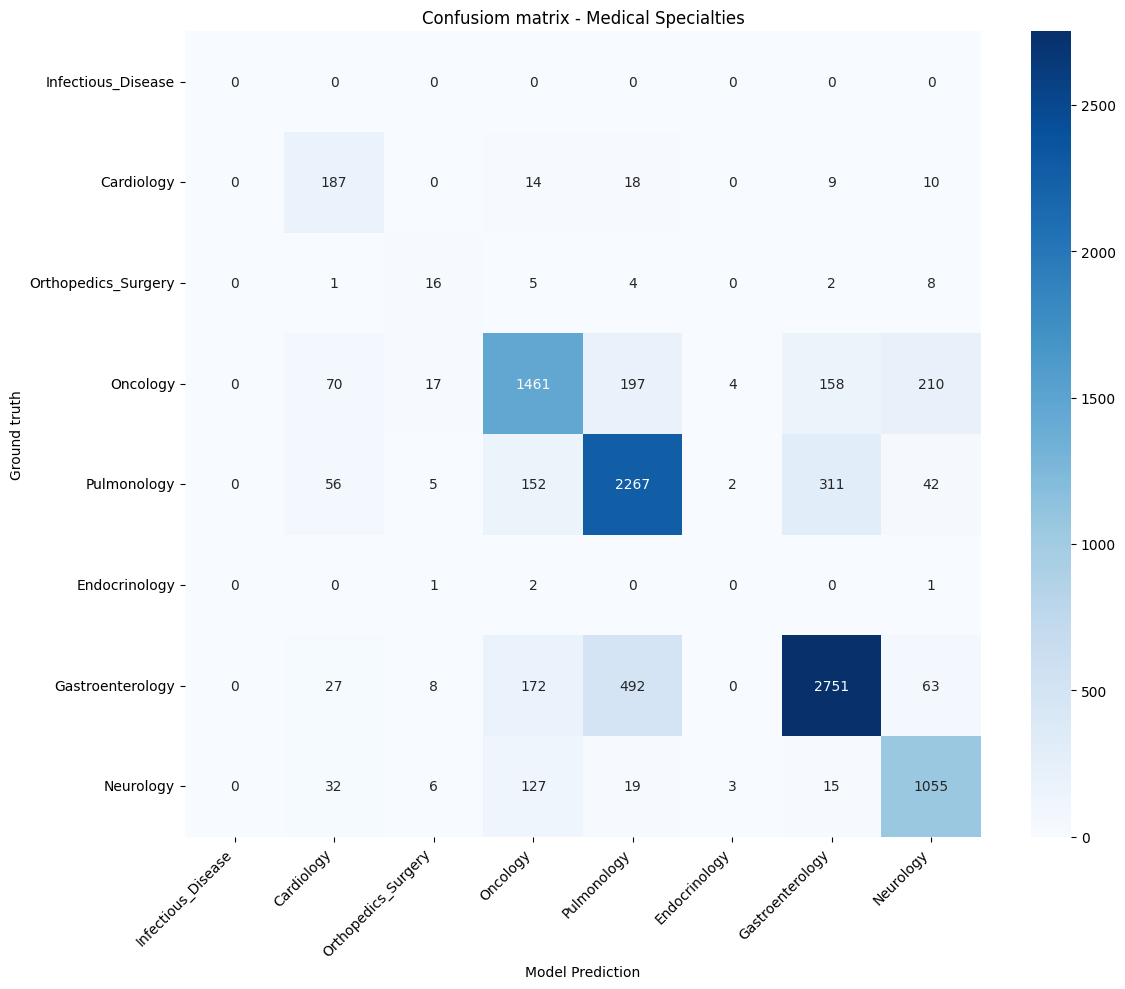

In [57]:
# matricea de confuzie

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(true_labels, predictions, labels=range(NUM_LABELS))

plt.figure(figsize=(12, 10))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=target_names,
    yticklabels=target_names
)
plt.xlabel('Model Prediction')
plt.ylabel('Ground truth')
plt.title('Confusiom matrix - Medical Specialties')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
import torch.nn.functional as F

# functie pentru inferenta (simulare utilizare de catre un pacient)

def get_specialits(pacient_text, model, tokenizer, device, threshold=0.6):
    """
    Simulează un caz real.
    Input: Text descris de pacient (string).
    Output: Specialist recomandat și scorul de încredere.
    """
    model.eval()
    
    text_clean = clean_text(pacient_text, ALL_STOPWORDS)
    # text_clean = pacient_text - BioBERT se descurcă bine și cu text brut
    
    # 2. Tokenizare
    inputs = tokenizer(
        text_clean, 
        return_tensors="pt", 
        truncation=True, 
        max_length=512,
        padding=True
    ).to(device)
    
    # 3. Predicție
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
    
    # 4. Calculăm probabilitățile (Softmax)
    probs = F.softmax(logits, dim=-1)
    
    # Luăm clasa cu probabilitatea maximă
    max_prob, predicted_class_id = torch.max(probs, dim=-1)
    
    score = max_prob.item()
    predicted_label = model.config.id2label[predicted_class_id.item()]
    
    # 5. Logică de decizie (Threshold)
    if score < threshold:
        return {
            "specialist": "Human triage is needed!",
            "motiv": "Model is not confident",
            "confidence": f"{score:.2%}",
            "raw_prediction": predicted_label
        }
    
    return {
        "specialist": predicted_label,
        "confidence": f"{score:.2%}"
    }

In [51]:
import time
import os
import torch

def eval_efficiency(model, tokenizer, device, sample_text="Patient presents with severe chest pain and shortness of breath."):
    model.eval()
    model.to(device)
    
    # 1. Dimensiune Model (Număr Parametri)
    num_params = sum(p.numel() for p in model.parameters())
    print(f" Număr Parametri: {num_params / 1e6:.2f} milioane")

    # 2. Dimensiune pe Disk (estimare salvare temporară)
    temp_path = "./model/temp_model_size.pth"
    torch.save(model.state_dict(), temp_path)
    size_mb = os.path.getsize(temp_path) / (1024 * 1024)
    print(f"Dimensiune pe Disk: {size_mb:.2f} MB")
    os.remove(temp_path) # Curățăm

    inputs = tokenizer(sample_text, return_tensors="pt", truncation=True, max_length=512).to(device)
    
    # Warm-up (pentru a încălzi GPU-ul/Cache-ul)
    print("Warming up GPU...")
    for _ in range(10):
        with torch.no_grad():
            _ = model(**inputs)
            
    # Măsurare reală
    num_runs = 100
    start_time = time.time()
    with torch.no_grad():
        for _ in range(num_runs):
            _ = model(**inputs)
    end_time = time.time()
    
    total_time = end_time - start_time
    avg_latency = (total_time / num_runs) * 1000 # milisecunde
    throughput = num_runs / total_time
    
    print(f"Latency (Timp per predicție): {avg_latency:.2f} ms")
    print(f"Throughput: {throughput:.2f} predicții/secundă")
    
    return size_mb, avg_latency

# Rulează evaluarea
size, speed = eval_efficiency(final_model, tokenizer, DEVICE)

 Număr Parametri: 108.32 milioane
Dimensiune pe Disk: 413.27 MB
Warming up GPU...
Latency (Timp per predicție): 4.78 ms
Throughput: 209.32 predicții/secundă


In [56]:
import shap
import transformers
# SHAP este recomandat pentru NLP-uri, acesta ilustrand tokenii cei mai importanti pentru decizia luata (cu rosu), respectiv tokenii care "impingeau" spre alta predictie (cu albastru)

# SHAP are nevoie de o funcție care primește text și returnează scoruri
pred = transformers.pipeline("text-classification", model=final_model, tokenizer=tokenizer, device=0, top_k=7)

# 2. Inițializăm Explainer-ul SHAP
# Acesta "sparge" modelul BERT pentru a vedea contribuția fiecărui token
explainer = shap.Explainer(pred)

# 3. Alegem un text de test
text_test = ["Patient denies chest pain but has severe headache and numbness in left leg."]

# 4. Calculăm valorile SHAP
shap_values = explainer(text_test)

# 5. Vizualizare
# Asta va genera un grafic colorat direct în Notebook
shap.plots.text(shap_values)

Device set to use cuda:0
